In [17]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf

In [25]:
dataset_name = "ann_2014-01-01_2022-02-28"
df_dataset = pd.read_csv(f"dataset/{dataset_name}.csv", header=0, parse_dates=["timestamp"], index_col=0)

FEATURES = 3
label_name = "Eeg_label"

baseline = f"{dataset_name}_{label_name}"

features = df_dataset.iloc[:,0:FEATURES].values
label = df_dataset.loc[:, label_name].values.reshape(-1,1)

x_train = features[0:int(len(features)*0.7)]
x_valid = features[int(len(features)*0.7):int(len(features)*0.8)]
x_test = features[int(len(features)*0.8):]

y_train = label[0:int(len(label)*0.7)]
y_valid = label[int(len(label)*0.7):int(len(label)*0.8)]
y_test = label[int(len(label)*0.8):]

In [26]:
input_layer = tf.keras.layers.Input(shape=(FEATURES))
ann_1 = tf.keras.layers.Dense(128, activation="relu")(input_layer)
ann_2 = tf.keras.layers.Dense(64, activation="relu")(ann_1)
ann_3 = tf.keras.layers.Dense(32, activation="relu")(ann_2)
output_layer = tf.keras.layers.Dense(1, activation=None)(ann_3)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss, optimizer=opt)

# model.summary()

In [27]:
PATH_SAVE = f"models/{baseline}"
if not os.path.exists(PATH_SAVE):
    os.makedirs(PATH_SAVE)

checkpoint_model = tf.keras.callbacks.ModelCheckpoint(filepath=PATH_SAVE + "/ann-" + label_name + "-{epoch:04d}-{val_loss:.04f}.h5",
                                                      monitor='val_loss',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode='auto',
                                                      save_freq='epoch')
stopping_criterion = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=200,
                                                      verbose=1,
                                                      mode='auto')

history_model = model.fit(x = x_train, y = y_train, epochs=1000, batch_size=32, validation_data=(x_valid, y_valid),
                          callbacks=[checkpoint_model, stopping_criterion])

json.dump(history_model.history, open(f"history/{baseline}.json", 'w'))

Epoch 1/1000
3394/3413 [============================>.] - ETA: 0s - loss: 12422.7051
Epoch 1: val_loss improved from inf to 8342.17480, saving model to models/ann_2014-01-01_2022-02-28_Eeg_label\ann-Eeg_label-0001-8342.1748.h5
3413/3413 [==============================] - 10s 3ms/step - loss: 12398.9443 - val_loss: 8342.1748
Epoch 2/1000
3399/3413 [============================>.] - ETA: 0s - loss: 8590.3877
Epoch 2: val_loss did not improve from 8342.17480
3413/3413 [==============================] - 8s 2ms/step - loss: 8588.5488 - val_loss: 8569.3037
Epoch 3/1000
3396/3413 [============================>.] - ETA: 0s - loss: 8231.6758
Epoch 3: val_loss improved from 8342.17480 to 7020.81689, saving model to models/ann_2014-01-01_2022-02-28_Eeg_label\ann-Eeg_label-0003-7020.8169.h5
3413/3413 [==============================] - 9s 3ms/step - loss: 8238.9053 - val_loss: 7020.8169
Epoch 4/1000
3395/3413 [============================>.] - ETA: 0s - loss: 8110.9189
Epoch 4: val_loss did not imp

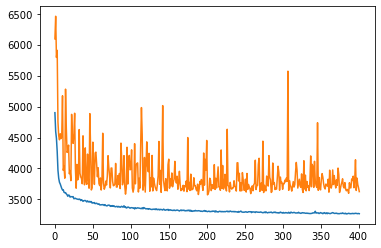

In [24]:
from matplotlib import pyplot as plt

history_data = json.load(open(f"history/{baseline}.json", 'r'))
plt.plot(history_data["loss"])
plt.plot(history_data["val_loss"])